#데이콘 Basic 여행 상품 신청 여부 예측 경진대회 -1 출처 : 마라맛 개발자

출처 : https://dacon.io/competitions/official/235959/codeshare

##문제를 풀어낸 순서

1. 라이브러리 불러오기

2. 데이터 불러오기

3. EDA  & 전처리

  3.1 EDA

        3.1.1 수치형 데이터

        3.1.2 범주형 데이터
  
  3.2 전처리

        3.2.1 결측치 처리

        3.2.2 스케일링

        3.2.3 인코딩

4. 모델링

  4.1 split

  4.2 성능 검증용 함수

  4.3 모델 automl로 선정

5. 제출

## 1. 라이브러리 불러오기

In [73]:
!pip install pycaret

!pip install markupsafe==2.1.1

!pip install pandas-profiling==3.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.0.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (31 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1


In [74]:
import numpy

In [75]:
import imp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

import lightgbm 

from pycaret.classification import *

import warnings
warnings.filterwarnings('ignore')


이때 몇가지 이슈가 발생

대표적으로 pycaret에서 계속 오류가 발생. automl할때 쓰는 건데 좀 앞으로 알아두면 좋을듯?

importerror: missing optional dependency 'jinja2'.

이때

    !pip install pycaret

    !pip install markupsafe==2.1.1

    !pip install pandas-profiling==3.1.0

을 사용해서 해결

## 2. 데이터 불러오기

In [76]:
!pip install gdrive_dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
from gdrivedataset import loader
file_id = '15qA4X0jTAhYUyiW-rq81rQGXWCC7_CSB'
loader.load_from_google_drive(file_id)

========== files ============

data/test.csv
data/train.csv
data/sample_submission.csv



In [78]:
!unzip -qq '/content/dataset.zip' # 압축파일 경로

replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [79]:
test_df = pd.read_csv('test.csv')

In [80]:
train_df = pd.read_csv('train.csv')

In [81]:
train_df

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,ProdTaken
0,1,28.0,Company Invited,1,10.0,Small Business,Male,3,4.0,Basic,3.0,Married,3.0,0,1,0,1.0,Executive,20384.0,0
1,2,34.0,Self Enquiry,3,NaN,Small Business,Female,2,4.0,Deluxe,4.0,Single,1.0,1,5,1,0.0,Manager,19599.0,1
2,3,45.0,Company Invited,1,NaN,Salaried,Male,2,3.0,Deluxe,4.0,Married,2.0,0,4,1,0.0,Manager,NaN,0
3,4,29.0,Company Invited,1,7.0,Small Business,Male,3,5.0,Basic,4.0,Married,3.0,0,4,0,1.0,Executive,21274.0,1
4,5,42.0,Self Enquiry,3,6.0,Salaried,Male,2,3.0,Deluxe,3.0,Divorced,2.0,0,3,1,0.0,Manager,19907.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,1951,28.0,Self Enquiry,1,10.0,Small Business,Male,3,5.0,Basic,3.0,Single,2.0,0,1,1,2.0,Executive,20723.0,0
1951,1952,41.0,Self Enquiry,3,8.0,Salaried,Female,3,3.0,Super Deluxe,5.0,Divorced,1.0,0,5,1,1.0,AVP,31595.0,0
1952,1953,38.0,Company Invited,3,28.0,Small Business,Female,3,4.0,Basic,3.0,Divorced,7.0,0,2,1,2.0,Executive,21651.0,0
1953,1954,28.0,Self Enquiry,3,30.0,Small Business,Female,3,5.0,Deluxe,3.0,Married,3.0,0,1,1,2.0,Manager,22218.0,0


In [82]:
test_df

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,1,32.0,Company Invited,3,NaN,Small Business,Male,2,5.0,Deluxe,3.0,Married,1.0,0,2,0,1.0,Manager,19668.0
1,2,46.0,Self Enquiry,2,11.0,Small Business,Male,3,NaN,Deluxe,4.0,Married,1.0,1,5,0,1.0,Manager,20021.0
2,3,37.0,Self Enquiry,3,22.0,Small Business,Male,3,4.0,Deluxe,3.0,Married,5.0,0,5,1,0.0,Manager,21334.0
3,4,43.0,Self Enquiry,1,36.0,Small Business,Male,3,6.0,Deluxe,3.0,Unmarried,6.0,0,3,1,2.0,Manager,22950.0
4,5,25.0,Self Enquiry,3,7.0,Large Business,Female,4,4.0,Basic,4.0,Unmarried,3.0,1,4,1,3.0,Executive,21880.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,2929,54.0,Self Enquiry,1,6.0,Small Business,Female,2,3.0,Super Deluxe,3.0,Single,7.0,0,4,1,1.0,AVP,32328.0
2929,2930,33.0,Self Enquiry,1,9.0,Small Business,Fe Male,4,2.0,Deluxe,3.0,Unmarried,2.0,0,3,0,1.0,Manager,23733.0
2930,2931,33.0,Company Invited,1,31.0,Salaried,Male,4,4.0,Deluxe,3.0,Divorced,3.0,0,4,1,1.0,Manager,23987.0
2931,2932,26.0,Self Enquiry,1,9.0,Small Business,Male,4,2.0,Basic,5.0,Unmarried,2.0,0,2,1,3.0,Executive,22102.0


In [83]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1955 non-null   int64  
 1   Age                       1861 non-null   float64
 2   TypeofContact             1945 non-null   object 
 3   CityTier                  1955 non-null   int64  
 4   DurationOfPitch           1853 non-null   float64
 5   Occupation                1955 non-null   object 
 6   Gender                    1955 non-null   object 
 7   NumberOfPersonVisiting    1955 non-null   int64  
 8   NumberOfFollowups         1942 non-null   float64
 9   ProductPitched            1955 non-null   object 
 10  PreferredPropertyStar     1945 non-null   float64
 11  MaritalStatus             1955 non-null   object 
 12  NumberOfTrips             1898 non-null   float64
 13  Passport                  1955 non-null   int64  
 14  PitchSat

여기서 잠깐 스탑

지금 info문으로 우리는 대략적인 데이터에 대해 알게되었습니다,

여기서  Non-Null Count 이부분 한번 보시면 

데이터의 갯수가 각각 다른것을 알 수 있습니다.

최대치가 1955인데 최소치가 1800대까지 떨어지네요.

선택지는 3가지
1. 삭제
2. 0으로 채우기
3. 평균치로 채우기
4. Regression imputation

등..... 여러가지가 존재한다.

여기서는 mean을 사용


결측치 처리 가이드 라인

10% 미만 : 삭제 or 대치

10% ~ 50% : regression or model based imputation

50% 이상 : 해당 컬럼(변수) 자체 제거

데이터 정의서
<pre>
id : 샘플 아이디
Age : 나이
TypeofContact : 고객의 제품 인지 방법 (회사의 홍보 or 스스로 검색)
CityTier : 주거 중인 도시의 등급. (인구, 시설, 생활 수준 기준) (1등급 > 2등급 > 3등급) 
DurationOfPitch : 영업 사원이 고객에게 제공하는 프레젠테이션 기간
Occupation : 직업
Gender : 성별
NumberOfPersonVisiting : 고객과 함께 여행을 계획 중인 총 인원
NumberOfFollowups : 영업 사원의 프레젠테이션 후 이루어진 후속 조치 수
ProductPitched : 영업 사원이 제시한 상품
PreferredPropertyStar : 선호 호텔 숙박업소 등급
MaritalStatus : 결혼여부
NumberOfTrips : 평균 연간 여행 횟수
Passport : 여권 보유 여부 (0: 없음, 1: 있음)
PitchSatisfactionScore : 영업 사원의 프레젠테이션 만족도
OwnCar : 자동차 보유 여부 (0: 없음, 1: 있음)
NumberOfChildrenVisiting : 함께 여행을 계획 중인 5세 미만의 어린이 수
Designation : (직업의) 직급
MonthlyIncome : 월 급여
ProdTaken : 여행 패키지 신청 여부 (0: 신청 안 함, 1: 신청함)
</pre>

## 3. EDA & 전처리

EDA란? 수집한 데이터가 들어왔을 때, 이를 다양한 각도에서 관찰하고 이해하는 과정

In [84]:
train_df.rename(columns={
'id' : '아이디'
,'Age' : '나이'
,'TypeofContact' : '탐색경로'
,'CityTier' : '도시등급'
,'DurationOfPitch' : '프리젠테이션기간'
,'Occupation' : '직업'
,'Gender' : '성별'
,'NumberOfPersonVisiting' : '여행인원'
,'NumberOfFollowups' : '후속조치수'
,'ProductPitched' : '제시상품'
,'PreferredPropertyStar' : '선호숙박등급'
,'MaritalStatus' : '결혼여부'
,'NumberOfTrips' : '연간여행횟수'
,'Passport' : '여권보유'
,'PitchSatisfactionScore' : '프레젠테이션만족도'
,'OwnCar' : '자동차보유'
,'NumberOfChildrenVisiting' : '미취학아동'
,'Designation' : '직급'
,'MonthlyIncome' : '월급여'
,'ProdTaken' : '신청여부'
}, inplace = True)
test_df.rename(columns = {
'id' : '아이디'
,'Age' : '나이'
,'TypeofContact' : '탐색경로'
,'CityTier' : '도시등급'
,'DurationOfPitch' : '프리젠테이션기간'
,'Occupation' : '직업'
,'Gender' : '성별'
,'NumberOfPersonVisiting' : '여행인원'
,'NumberOfFollowups' : '후속조치수'
,'ProductPitched' : '제시상품'
,'PreferredPropertyStar' : '선호숙박등급'
,'MaritalStatus' : '결혼여부'
,'NumberOfTrips' : '연간여행횟수'
,'Passport' : '여권보유'
,'PitchSatisfactionScore' : '프레젠테이션만족도'
,'OwnCar' : '자동차보유'
,'NumberOfChildrenVisiting' : '미취학아동'
,'Designation' : '직급'
,'MonthlyIncome' : '월급여'
,'ProdTaken' : '신청여부'
}, inplace = True)


### 2.1 EDA

#### 2.1.1 수치형 데이터 탐색

수치형 데이터를 의미하는 코드

    train_df.select_dtypes(exclude=['object']).columns

In [85]:
print(train_df.select_dtypes(exclude=['object']).columns)

Index(['아이디', '나이', '도시등급', '프리젠테이션기간', '여행인원', '후속조치수', '선호숙박등급', '연간여행횟수',
       '여권보유', '프레젠테이션만족도', '자동차보유', '미취학아동', '월급여', '신청여부'],
      dtype='object')


In [86]:
train_df.describe()

,아이디,나이,도시등급,프리젠테이션기간,여행인원,후속조치수,선호숙박등급,연간여행횟수,여권보유,프레젠테이션만족도,자동차보유,미취학아동,월급여,신청여부
count,1955.000000,1861.000000,1955.000000,1853.000000,1955.000000,1942.000000,1945.000000,1898.000000,1955.000000,1955.000000,1955.000000,1928.000000,1855.000000,1955.000000
mean,978.000000,37.462117,1.641432,15.524015,2.922762,3.718332,3.568638,3.255532,0.291049,3.067519,0.619437,1.213174,23624.108895,0.195908
std,564.504207,9.189948,0.908744,8.150057,0.712276,1.004095,0.793196,1.814698,0.454362,1.372915,0.485649,0.859450,5640.482258,0.397000
min,1.000000,18.000000,1.000000,5.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1000.000000,0.000000
25%,489.500000,31.000000,1.000000,9.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,0.000000,1.000000,20390.000000,0.000000
50%,978.000000,36.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,3.000000,1.000000,1.000000,22295.000000,0.000000
75%,1466.500000,43.000000,3.000000,20.000000,3.000000,4.000000,4.000000,4.000000,1.000000,4.000000,1.000000,2.000000,25558.000000,0.000000
max,1955.000000,61.000000,3.000000,36.000000,5.000000,6.000000,5.000000,19.000000,1.000000,5.000000,1.000000,3.000000,98678.000000,1.000000


In [87]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.1.0 requires matplotlib>=3.2.0, but you have matplotlib 3.1.3 which is incompatible.


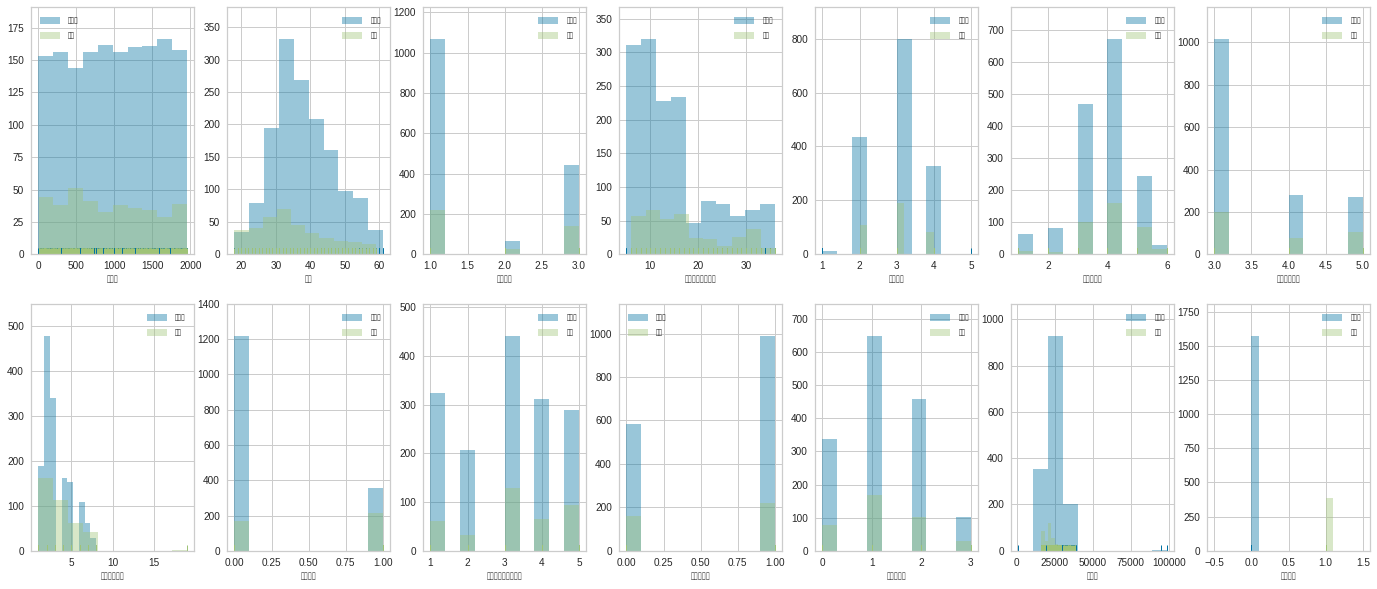

In [88]:
cols = train_df.select_dtypes(exclude=['object']).columns
fig, axes = plt.subplots(2, 7,  figsize=(24,10))
for i, col in enumerate(cols):
#7:2 형태로 그래프를 만들기 위해서
#j와 k는 0부터 시작하는 배열이라고 생각하면 쉽다.
    if i <=6:
        k = i
        j  = 0
    else:
        j = 1
        k = i-7
    g = sns.distplot(train_df[train_df['신청여부']==0][col], hist=True, kde=False, rug=True, bins=10, label="미신청"   , ax = axes[j][k])
    h = sns.distplot(train_df[train_df['신청여부']==1][col], hist=True, kde=False, rug=True, bins=10, label="신청", ax = axes[j][k])
    axes[j][k].legend()
    plt.xlabel(col)
plt.show()
plt.close()

신청 한 인원들의 분포와 신청하지 않은 인원들의 분포가 거의 똑같다고 볼 수 있다.

이상치 확인하기

이상치란 : 이상치는 관측치들이 주로 모여 있는 곳에서 멀리 떨어져 있어 특정 그룹으로 분류되지
못하는 값으로, 정상군의 상한과 하한의 범위를 벗어난 자료를 의미한다. 이상치는 자료들
의 분포에 따라 대푯값에 영향을 준다. 

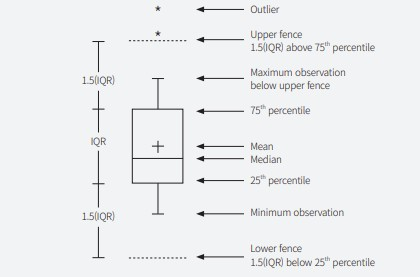

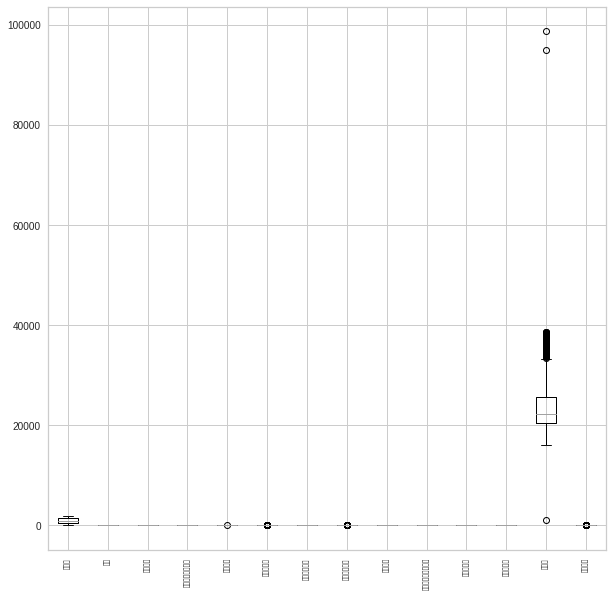

In [89]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
#박스 플롯
#최소값
#제 1사분위 수 (Q1)
#제 2사분위 수 또는 중위수 (Q2)
#제 3사분위 수 (Q3)
#보통 이상치를 볼때는 박스 plot을 사용해서 찾는다.
train_df.boxplot(ax = ax)
#label을 회전
plt.xticks(rotation = 90)
plt.show()

월 급여 특성의 분포로 인해 분포가 앞축된 것을 볼 수 있다. 

데이터 분포를 잘 보기 위해 월 급여를 일단 제외하고 다시 boxplot을 그린다.

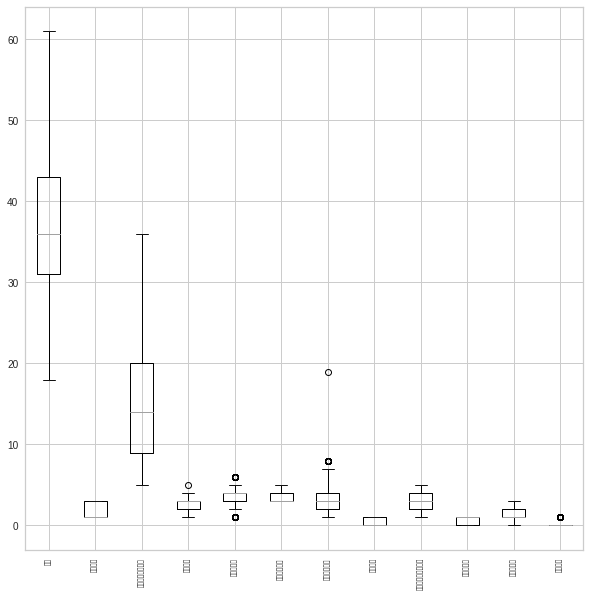

In [90]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
train_df.drop(['월급여', '아이디'], axis = 1).boxplot(ax = ax)
plt.xticks(rotation = 90)
plt.show()

여행인원, 후속조치수, 평균 연간 여행횟수, 월 급여의 분포에 이상치가 존재하는 것을 확인할 수 있다.

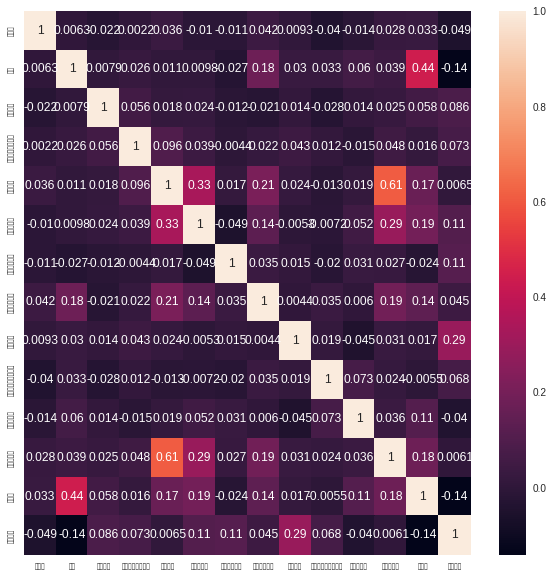

In [91]:
#상관분석하기
#각 변수가 어떤 상관 관계가 있는지. 수치가 높을수록 관계가 있다는 것이다.
fig = plt.figure(figsize = (10,10))
sns.heatmap(train_df.corr(), annot = True)
plt.show()

<pre>
위의 히트맵으로 아래와 같이 약 상관관계가 있는 특성들을 볼 수 있다.
나이와 월 급여(0.44) - 나이가 많을 수록 경력도 쌓인다는 것을 볼 수 있다.
여행인원과 미취학아동(0.61) - 같이 여행가는 미취학 아동이 많을수록 여행인원이 많아지는 것을 알 수 있다.

#### 2.2.2 범주형 데이터 탐색

In [92]:
print(train_df.select_dtypes(include=['object']).columns)

Index(['탐색경로', '직업', '성별', '제시상품', '결혼여부', '직급'], dtype='object')


범주형 데이터에는 sns.countplot을 사용하면 깔끔하게 구분이 된다.

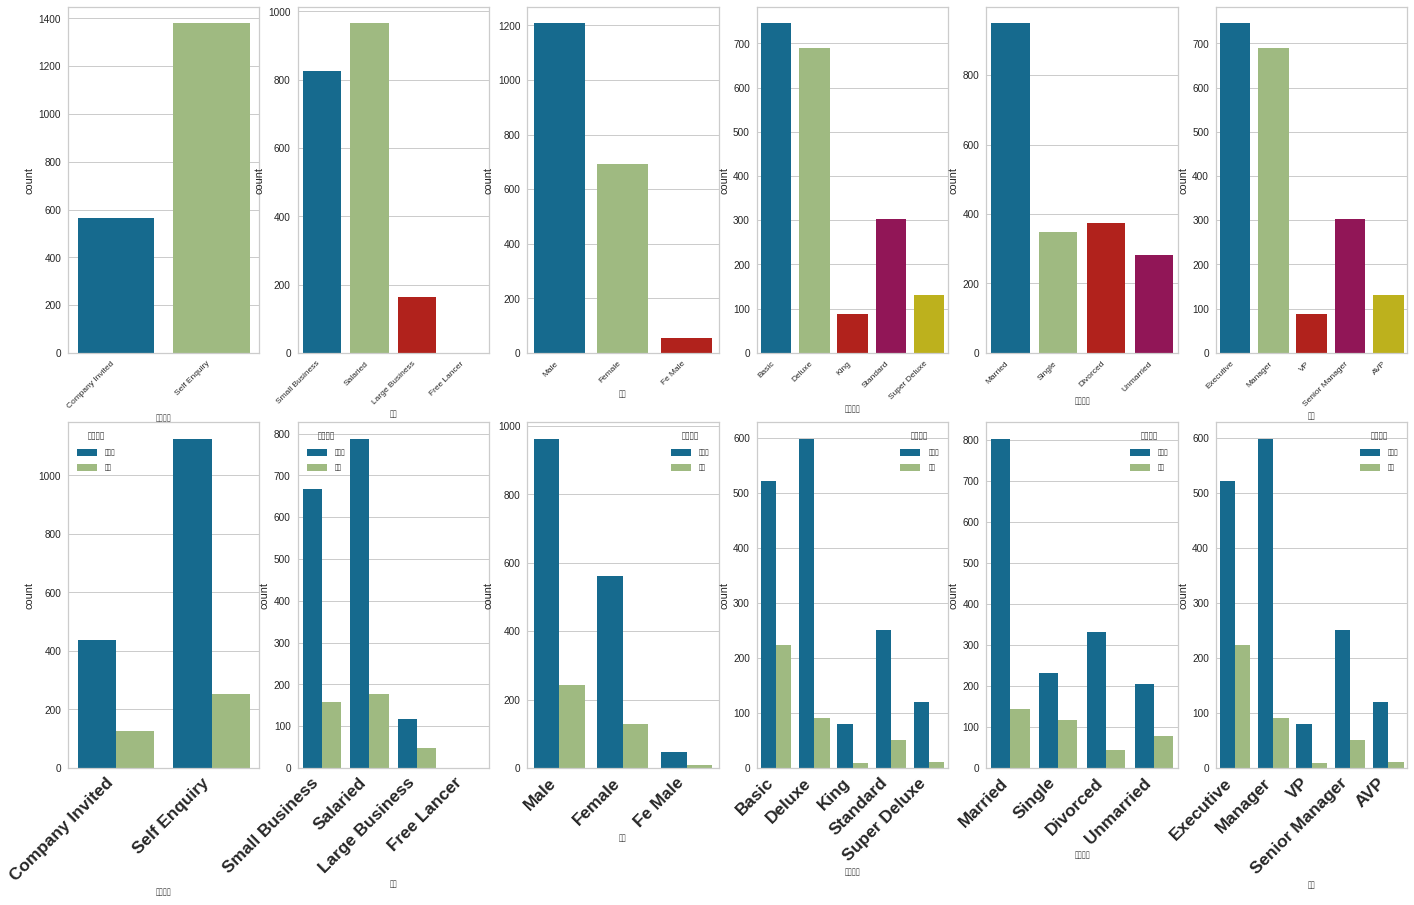

In [93]:
fig, axes = plt.subplots(2, 6,  figsize=(24,14))
#이건 전체 데이터의 구성을 살펴보는 코드
#원래 범주형 데이터라 카테고리로 정렬되어 있음
#그래서 처음 반복문은 이 처음 카테고리를 보는 것
for i, col in enumerate(['탐색경로', '직업', '성별', '제시상품', '결혼여부', '직급']):
    g = sns.countplot(train_df[col] , ax = axes[0][i])
    # axes[i].legend()
    g.set_xticklabels(g.get_xticklabels(), rotation=45,
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-small'
                 )
    plt.xlabel(col)
#이건 사용, 미사용에 따라 분류하는 코드
for i, col in enumerate(['탐색경로', '직업', '성별', '제시상품', '결혼여부', '직급']):
    g = sns.countplot(train_df[col],  hue = train_df['신청여부'].map({0:'미신청', 1:'신청'}) , ax = axes[1][i])
    # axes[i].legend()
    g.set_xticklabels(g.get_xticklabels(), rotation=45,
                  horizontalalignment='right',
                  fontweight='heavy',
                  fontsize='x-large'
                 )
    plt.xlabel(col)


plt.show()
plt.close()

<pre>
탐색 경로는 직접 탐색해서 문의한 고객이 여행사의 마케팅을 통해 유입된 고객보다 많다.
직업은 작은 사업을 하는 사람과 월급을 받는 직장인의 방문 비율이 가장 높다.
성별로 봤을 때, 여성보다 남성의 방문 비율과 신청 건수가 더 많다.
제시 상품으로 봤을 때, 베이직과 딜럭스의 비중이 많았고, 그중 베이직의 신청건수가 더 많다. 
결혼여부로 봤을 때, 기혼 인원의 비중이 가장 많았고, 싱글의 상담 비중은 크지 않았지만, 신청 건수는 기혼 인원과 거의 비슷하다.
직급으로 봤을 때, 경영진과 매니저의 비중이 가장 많다.

### 2.2 전처리

불필요한 아이디 특성 제거한다.

In [94]:
train_df.drop('아이디', axis =1 ,inplace = True)
test_df.drop('아이디', axis =1 , inplace = True)

#### 2.2.1 결측치 처리

isna()함수를 사용해서 결측치가 몇개 있는지 확인

In [95]:
round(train_df.isna().sum()[train_df.isna().sum()>0]/len(train_df),3)

나이          0.048
탐색경로        0.005
프리젠테이션기간    0.052
후속조치수       0.007
선호숙박등급      0.005
연간여행횟수      0.029
미취학아동       0.014
월급여         0.051
dtype: float64

In [96]:
round(test_df.isna().sum()[test_df.isna().sum()>0]/len(test_df),3)

나이          0.045
탐색경로        0.005
프리젠테이션기간    0.051
후속조치수       0.011
선호숙박등급      0.005
연간여행횟수      0.028
미취학아동       0.013
월급여         0.045
dtype: float64

우선 데이터의 복사본을 만든다.

결측치를 다룰때는 데이터를 삭제하거나 여러 조작을 가하니까 항상 데이터의 복사본을 만드는거 잊지말자.

In [97]:
train_df_cp = train_df.copy()
test_df_cp = test_df.copy()

월급여 결측치는 직급의 별 월 급여 평균으로 대체한다.

In [98]:
train_df_cp['월급여'] = train_df_cp['월급여'].fillna(train_df_cp.groupby('직급')['월급여'].transform('mean'))
test_df_cp['월급여'] = test_df_cp['월급여'].fillna(test_df_cp.groupby('직급')['월급여'].transform('mean'))


나이의 결측치도 직급 별 평균 나이대로 대체한다.

In [99]:
train_df_cp['나이'] = train_df_cp['나이'].fillna(train_df_cp.groupby('직급')['나이'].transform('mean'))
test_df_cp['나이'] = test_df_cp['나이'].fillna(test_df_cp.groupby('직급')['나이'].transform('mean'))


탐색경로, 프리젠테이션기간, 후속조치수, 선호 숙박 등급, 평균 연간 여행 횟수, 미취학 아동 수는 최빈수로 채우고, 월 급여는 평균으로 채운다.

In [100]:
fre_col = ['탐색경로', '후속조치수', '프리젠테이션기간', '선호숙박등급', '연간여행횟수', '미취학아동']
imputer_fre = SimpleImputer(strategy = 'most_frequent')
imputer_fre.fit(train_df_cp[fre_col])
train_df_cp[fre_col] = imputer_fre.transform(train_df_cp[fre_col])
test_df_cp[fre_col] = imputer_fre.transform(test_df_cp[fre_col])


### 2.2.2 스케일링

In [101]:
#수치형 데이터 스케일링
cols = test_df.select_dtypes(exclude=['object']).columns

scaler = MinMaxScaler()

# 학습용 데이터를 이용해 scaler를 학습시킵니다.
scaler.fit(train_df_cp[cols])
# 학습된 scaler를 사용해 데이터를 변환합니다.
scaled = scaler.transform(train_df_cp[cols])

# 변환된 값을 새로운 column에 할당합니다.
train_df_cp[cols] = scaled

scaled_test = scaler.transform(test_df_cp[cols])

# 변환된 값을 새로운 column에 할당합니다.
test_df_cp[cols] = scaled_test

#### 2.2.3 인코딩

In [102]:
#범주형 데이터는 인코딩 해야 한다.
for col in train_df_cp.select_dtypes('object').columns:
    encoder = LabelEncoder()
    encoder.fit(train_df_cp[col])
    train_df_cp[col] = encoder.transform(train_df_cp[col])
    for label in np.unique(test_df_cp[col]):
        if label not in encoder.classes_: 
            encoder.classes_ = np.append(encoder.classes_, label)
    test_df_cp[col] = encoder.transform(test_df_cp[col])

## 3. 모델링

### 3.0 데이터 분리

훈련용과 검증용 데이터 분리

target은 label 데이터 이며, 예측해야 할 (class) 데이터 이므로 data를 스플릿 해줄때 만약 이게 포함되어 있으면, 배제해야 한다.

그리고 판다즈에서 axis = 0, axis = 1의 차이가 존재한다.

axis = 0은 행을 나타낸다

즉 만일 df.drop([1.2],axis=0)을 하면 행방향으로 1,2번째가 삭제된다.

그리고 만일 df.drop([1.2],axis=1)을 하면 열방향으로 삭제된다.

여기서는 열방향으로 삭제해야 신청여부 칼럼을 제외할 수 있으므로 열방향 삭제를 했다.

In [103]:
X,y = train_df_cp.drop("신청여부", axis =1), train_df_cp['신청여부']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

### 3.1 성능 검증용 함수

In [104]:
def plot_roc_curve( y_pred, y_prob):
    fper, tper, thresholds = roc_curve(y_test, y_prob[:,1])
    print('Confusion matrix')
    print(confusion_matrix(y_test, y_pred))

    print(f"Precision : {precision_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Recall    : {recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"F1        : {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Accuracy  : {accuracy_score(y_test, y_pred):.4f}")
    print(f"AUC       : {roc_auc_score(y_test, y_prob[:,1]):.4f}  ")
    plt.figure(figsize=(4,4))
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

### 3.2 모델

어떤 모델의 성능이 좋은지 보기위해, pycaret을 통해 분류모델들을 한번에 비교한다.

#### 3.2.0 AUTO ML 로 좋은 모델 찾기

In [105]:
from pycaret import classification

pycaret에서 set_up단계란  pycaret을 사용하기 위한 data setting하는 단계를 의미한다.

exp_clf = setup(data = train, target = 'default', session_id=123)

여기서는 fold_startegy를 default인 k_fold말고 stratifiedkfold를 사용한다.



In [106]:
classification_setup = classification.setup(data=train_df_cp, target='신청여부',fold_strategy='stratifiedkfold')

,Description,Value
0,session_id,7406
1,Target,신청여부
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1955, 19)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='신청여부',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strateg...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

이번 단계는 모델을 비교한다.



```
best_model = compare_models()
```



심사 기준 : accuracy 따라서 accuracy를 사용.

fold를 5개만 사용

소숫점 3번째 자리까지 반올림

n_select는 몇개의 Top 모델을 가져올것인지의 개수

compare_models(include: Optional[List[Union[str, Any]]] = None, exclude: Optional[List[str]] = None, fold: Optional[Union[int, Any]] = None, round: int = 4, cross_validation: bool = True, sort: str = 'Accuracy', n_select: int = 1, budget_time: Optional[float] = None, turbo: bool = True, errors: str = 'ignore', fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, experiment_custom_tags: Optional[Dict[str, Any]] = None, probability_threshold: Optional[float] = None, engines: Optional[Dict[str, str]] = None, verbose: bool = True, parallel: Optional[ParallelBackend] = None)→ Union[Any, List[Any]]

In [107]:
top5_model = classification.compare_models(fold = 5, round = 3, sort = 'Accuracy', n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.865,0.860,0.406,0.800,0.535,0.467,0.505,0.524
rf,Random Forest Classifier,0.852,0.848,0.316,0.809,0.453,0.386,0.444,0.530
lightgbm,Light Gradient Boosting Machine,0.849,0.836,0.425,0.677,0.521,0.437,0.454,0.142
lda,Linear Discriminant Analysis,0.845,0.803,0.372,0.689,0.480,0.399,0.427,0.014
lr,Logistic Regression,0.843,0.801,0.323,0.707,0.442,0.366,0.405,0.402
ridge,Ridge Classifier,0.839,0.000,0.252,0.757,0.377,0.311,0.374,0.012
gbc,Gradient Boosting Classifier,0.835,0.806,0.342,0.637,0.443,0.358,0.382,0.148
ada,Ada Boost Classifier,0.833,0.778,0.369,0.612,0.458,0.367,0.384,0.092
knn,K Neighbors Classifier,0.830,0.755,0.248,0.687,0.360,0.287,0.339,0.136
svm,SVM - Linear Kernel,0.806,0.000,0.530,0.540,0.520,0.402,0.411,0.014


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=7406, verbose=0,
                     warm_start=False), RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
 

et(Extra Trees Classifier)의 성능이 가장 좋게 나왔다.

우선 et로 모델링을 진행한다.

#### 3.2.1 Extra Trees Classifier

In [118]:
xtree = ExtraTreesClassifier(n_estimators=100, random_state=2022)
xtree.fit(X_train, y_train)

xtree.fit(X_train,y_train)
y_pred = xtree.predict(X_test)
computer_pred_proba = xtree.predict_proba(X_test)

Confusion matrix
[[318   8]
 [ 23  42]]
Precision : 0.8863
Recall    : 0.8108
F1        : 0.8420
Accuracy  : 0.9207
AUC       : 0.9414  


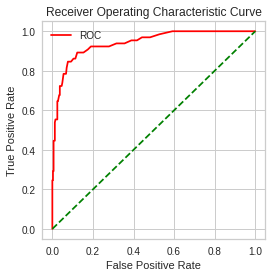

In [119]:
plot_roc_curve(y_pred, computer_pred_proba)

In [112]:
rf = RandomForestClassifier(n_estimators=200, random_state=2022)
rf.fit(X_train, y_train)

rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
computer_pred_proba = rf.predict_proba(X_test)

Confusion matrix
[[315  11]
 [ 33  32]]
Precision : 0.8247
Recall    : 0.7293
F1        : 0.7637
Accuracy  : 0.8875
AUC       : 0.9242  


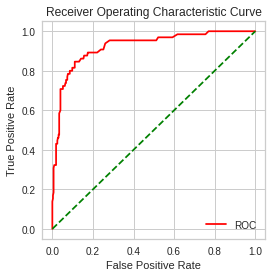

In [113]:
plot_roc_curve(y_pred, computer_pred_proba)

In [120]:
lgbm_wrapper = lightgbm.LGBMClassifier(n_estimators=100)
# lgbm또한 조기중단을 수행할 수 있다.
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "logloss", eval_set=evals, verbose=False)
y_pred = lgbm_wrapper.predict(X_test)
computer_pred_proba = lgbm_wrapper.predict_proba(X_test)

Confusion matrix
[[308  18]
 [ 32  33]]
Precision : 0.7765
Recall    : 0.7262
F1        : 0.7469
Accuracy  : 0.8721
AUC       : 0.9113  


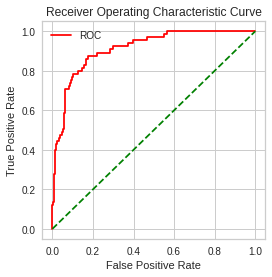

In [121]:
plot_roc_curve(y_pred, computer_pred_proba)

In [122]:
submission = pd.read_csv('./data/sample_submission.csv')

In [123]:
submission

,id,ProdTaken
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
2928,2929,0
2929,2930,0
2930,2931,0
2931,2932,0
